In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import time, os
import random
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorboard.plugins.hparams import api as hp

from tensorflow.keras import activations
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as split
from scipy.stats import bernoulli

from matplotlib.ticker import FormatStrFormatter

In [2]:
np.random.seed(0)
scaler = StandardScaler()

### Conjunto de datos: SDSS DR17

In [3]:
url = "https://raw.githubusercontent.com/igomezv/nnogada/main/data/star_classification.csv"
data = pd.read_csv(url)
cols = ['alpha','delta','u','g','r','i','z','class']
data = data[cols]
data.head()

,alpha,delta,u,g,r,i,z,class
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY


Se cambian las clases a vectores con números enteros

$$ \text{GALAXY}: \begin{pmatrix}1\\0\\0\end{pmatrix},\quad \text{STAR}: \begin{pmatrix}0\\1\\0\end{pmatrix},\quad \text{QSO}:\begin{pmatrix}0\\0\\1\end{pmatrix} $$

In [4]:
data["class"]=[0 if i == "GALAXY" else 1 if i == "STAR" else 2 for i in data["class"]]
print(data.head())
data = data.to_numpy()

        alpha      delta         u         g         r         i         z  \
0  135.689107  32.494632  23.87882  22.27530  20.39501  19.16573  18.79371   
1  144.826101  31.274185  24.77759  22.83188  22.58444  21.16812  21.61427   
2  142.188790  35.582444  25.26307  22.66389  20.60976  19.34857  18.94827   
3  338.741038  -0.402828  22.13682  23.77656  21.61162  20.50454  19.25010   
4  345.282593  21.183866  19.43718  17.58028  16.49747  15.97711  15.54461   

   class  
0      0  
1      0  
2      0  
3      0  
4      0  


In [5]:
# Divide data into X and Y and implement hot_ones in Y
def prepare_dataset(data):
    X, Y = np.empty((0)), np.empty((0))
    X = data[:,0:7]
    Y = data[:,7]
    Y = to_categorical(Y, num_classes=3)
    return X, Y

In [6]:
# Split dataset into train, validation and test sets
X,Y = prepare_dataset(data)

# Defines ratios, w.r.t. whole dataset.
ratio_train = 0.8
ratio_val = 0.1
ratio_test = 0.1

# Produces test split.
x_, X_test, y_, Y_test = split(X, Y, test_size = ratio_test, random_state=0)

# Adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining

# Produces train and val splits.
X_train, X_val, Y_train, Y_val = split(x_, y_, test_size=ratio_val_adjusted, random_state=0)

# Normalize and scale the input sets.
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
X_val   = scaler.transform(X_val)

### Arquitectura del modelo proveniente de la malla de hiperparámetros

In [7]:
t = time.time(); t_total = 0    
deep_layers = 4
num_units = 200
learning_rate = 1e-3
epochs = 50

my_callbacks = [tf.keras.callbacks.EarlyStopping(
                               monitor='val_loss', mode='min',
                               min_delta=0, 
                               patience=40,
                               verbose=1,
                               restore_best_weights=1)]
    

model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.InputLayer(int(X_train.shape[1],)))
model1.add(Dense(num_units, input_shape=(int(X_train.shape[1]),)))
    
for i in range(deep_layers):        
    model1.add(Dense(num_units, activation='relu'))
model1.add(Dense(3, activation=tf.nn.softmax))
    
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])
train1 = model1.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val),
                    callbacks=my_callbacks, batch_size=128, shuffle=1, verbose=1)
    
loss, score = model1.evaluate(X_val, Y_val)    
t = time.time()-t
print("Accuracy:", score, ", Elapsed time:", t)

Epoch 1/50
625/625 [==============================] - 2s 2ms/step - loss: 0.6297 - accuracy: 0.7480 - val_loss: 0.5234 - val_accuracy: 0.7967
Epoch 2/50
625/625 [==============================] - 1s 2ms/step - loss: 0.5165 - accuracy: 0.8036 - val_loss: 0.4845 - val_accuracy: 0.8134
Epoch 3/50
625/625 [==============================] - 1s 2ms/step - loss: 0.4789 - accuracy: 0.8228 - val_loss: 0.4475 - val_accuracy: 0.8330
Epoch 4/50
625/625 [==============================] - 1s 2ms/step - loss: 0.4309 - accuracy: 0.8424 - val_loss: 0.4088 - val_accuracy: 0.8501
Epoch 5/50
625/625 [==============================] - 1s 2ms/step - loss: 0.4092 - accuracy: 0.8511 - val_loss: 0.4028 - val_accuracy: 0.8527
Epoch 6/50
625/625 [==============================] - 1s 2ms/step - loss: 0.3983 - accuracy: 0.8544 - val_loss: 0.3952 - val_accuracy: 0.8583
Epoch 7/50
625/625 [==============================] - 1s 2ms/step - loss: 0.3881 - accuracy: 0.8601 - val_loss: 0.3904 - val_accuracy: 0.8532
Epoch 

In [8]:
def plot_cm(Y_test, Y_pred, labels, porcentaje=False, cbar=False, ax=None):
    matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred)   
    #Aquí se divide si queremos en porcentaje o números
    if porcentaje==False: 
        ax = sns.heatmap(matrix, annot=True, cmap="OrRd", cbar=cbar, cbar_kws={'label': 'scale'}, ax=ax)
#         ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    if porcentaje==True:
        m=np.zeros(matrix.shape)
        for j in range(0,matrix.shape[1]):
            m[:,j]=matrix[:,j]/np.sum(matrix[:,j])*100
            
        ax = sns.heatmap(m, annot=True,cmap='OrRd', cbar=cbar, cbar_kws={'label': 'scale'}, ax=ax)
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    # ax.set(xlabel="True label", ylabel="Predicted label")

    return ax

313/313 [==============================] - 0s 653us/step


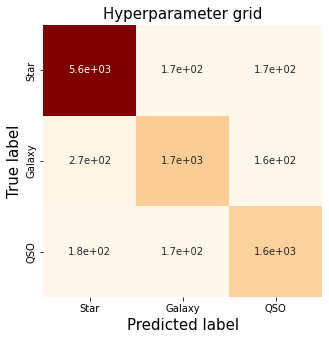

In [9]:
X_test_inverse = scaler.inverse_transform(X_test)
labels=['Star','Galaxy','QSO']
porcentaje = True

# titles.append(f"Confusion matrix model")
# plot_cm(Y_test, model1.predict(X_test), labels, porcentaje=porcentaje)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

y_pred = model1.predict(X_test)
y_test=np.argmax(Y_test, axis=1)
y_pred=np.argmax(y_pred, axis=1)
plot_cm(Y_test, y_pred, labels=labels, porcentaje=False, ax=ax)
plt.title("Hyperparameter grid", fontsize=15)
plt.xlabel("Predicted label", fontsize=15)
plt.ylabel("True label", fontsize=15)
plt.savefig("classification_grid_cm.png")

0.28584256768226624

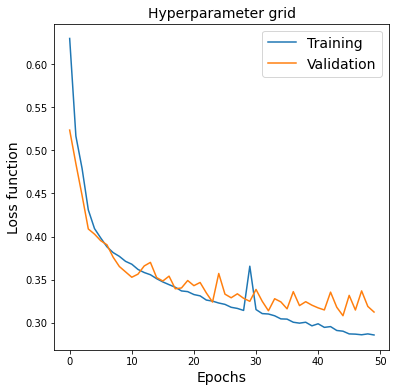

In [10]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
plt.plot(train1.history['loss'], label='Training')
plt.plot(train1.history['val_loss'], label='Validation')
# plt.ylim(0.25, 0.65)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.title("Hyperparameter grid", fontsize=14)
plt.ylabel('Loss function', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.savefig("classification_grid_loss.png")
np.min(train1.history['loss'])

In [11]:
model1.save("models/classification_grid.h5")

In [12]:
print("epochs", len(train1.history['loss']))

epochs 50


In [13]:
# other metrics
am = accuracy_score(y_test, y_pred)
pm = precision_score(y_test, y_pred, average='weighted')
# rm = roc_auc_score(y_test, y_pred,multi_class='ovr')
fm = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", am)
print("Precision:", pm)
print("F1:", fm)

Accuracy: 0.8879
Precision: 0.8869359847358017
F1: 0.8872894233625509


### Arquitectura del modelo proveniente del algoritmo genéticos (mismo número de evaluaciones que con la malla)

In [ ]:
t = time.time(); t_total = 0    
deep_layers = 6
num_units = 100
learning_rate = 1e-3
epochs = 50

my_callbacks = [tf.keras.callbacks.EarlyStopping(
                               monitor='val_loss', mode='min',
                               min_delta=0, 
                               patience=40,
                               verbose=1,
                               restore_best_weights=1)]
    

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.InputLayer(int(X_train.shape[1],)))
model2.add(Dense(num_units, input_shape=(int(X_train.shape[1]),)))
    
for i in range(deep_layers):        
    model2.add(Dense(num_units, activation='relu'))
model2.add(Dense(3, activation=tf.nn.softmax))
    
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])
train2 = model2.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val),
                    callbacks=my_callbacks, batch_size=128, shuffle=1, verbose=1)
    
loss, score = model2.evaluate(X_val, Y_val)    
t = time.time()-t
print("Accuracy:", score, ", Elapsed time:", t)

Epoch 1/50
625/625 [==============================] - 2s 3ms/step - loss: 0.6432 - accuracy: 0.7394 - val_loss: 0.5329 - val_accuracy: 0.7921
Epoch 2/50
625/625 [==============================] - 1s 2ms/step - loss: 0.5152 - accuracy: 0.8025 - val_loss: 0.4978 - val_accuracy: 0.8084
Epoch 3/50
625/625 [==============================] - 1s 2ms/step - loss: 0.4815 - accuracy: 0.8199 - val_loss: 0.4548 - val_accuracy: 0.8341
Epoch 4/50
625/625 [==============================] - 1s 2ms/step - loss: 0.4426 - accuracy: 0.8369 - val_loss: 0.4286 - val_accuracy: 0.8387
Epoch 5/50
625/625 [==============================] - 1s 2ms/step - loss: 0.4163 - accuracy: 0.8468 - val_loss: 0.3995 - val_accuracy: 0.8547
Epoch 6/50
625/625 [==============================] - 1s 2ms/step - loss: 0.4014 - accuracy: 0.8529 - val_loss: 0.3899 - val_accuracy: 0.8570
Epoch 7/50
625/625 [==============================] - 1s 2ms/step - loss: 0.3937 - accuracy: 0.8567 - val_loss: 0.3872 - val_accuracy: 0.8548
Epoch 

In [ ]:
X_test_inverse = scaler.inverse_transform(X_test)
labels=['Star','Galaxy','QSO']
porcentaje = True

# titles.append(f"Confusion matrix model")
# plot_cm(Y_test, model1.predict(X_test), labels, porcentaje=porcentaje)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

y_pred = model2.predict(X_test)
y_test=np.argmax(Y_test, axis=1)
y_pred=np.argmax(y_pred, axis=1)
plot_cm(Y_test, y_pred, labels=labels, porcentaje=False, ax=ax)
plt.xlabel("Predicted label", fontsize=15)
plt.ylabel("True label", fontsize=15)
plt.title("Genetic algorithm", fontsize=15)
plt.savefig("classification_genetic_cm.png")

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
plt.plot(train2.history['loss'], label='Training')
plt.plot(train2.history['val_loss'], label='Validation')
# plt.ylim(0.25, 0.65)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.ylabel('Loss function', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.title("Genetic algorithm", fontsize=14)
plt.savefig("classification_genetic_loss.png")

In [ ]:
model2.save("models/classification_genetic.h5")

In [ ]:
print("epochs", len(train2.history['loss']))

In [ ]:
# other metrics
am = accuracy_score(y_test, y_pred)
pm = precision_score(y_test, y_pred, average='weighted')
# rm = roc_auc_score(y_test, y_pred,multi_class='ovr')
fm = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", am)
print("Precision:", pm)
print("F1:", fm)